In this lab we'll look at:
- How to build ROC curves
- Use two different evaluation metrics to perform feature ranking
- Compare/contrast the results of feature ranking on different evaluation measures
- Build models on subsets of the features, using the different methods to select the subset
- Compare these different models


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os

%matplotlib inline

First we'll load the dataset and take a quick peak at its columns and size

In [2]:
#load dataset
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/data/'
f = datadir + 'ads_dataset_cut.txt'
data = pd.read_csv(f, sep = '\t')
data.columns, data.shape

(Index(['isbuyer', 'buy_freq', 'visit_freq', 'buy_interval', 'sv_interval',
        'expected_time_buy', 'expected_time_visit', 'last_buy', 'last_visit',
        'multiple_buy', 'multiple_visit', 'uniq_urls', 'num_checkins', 'y_buy'],
       dtype='object'), (54584, 14))

In the next step we'll use the Decision Tree classifier's built in feature importance attribute to compute the normalized Mutual Information/Information Gain of each feature. Note a few things about this approach: 1). With extremely high dimensional data, one may want to calculate the normalized MI directly for each feature (the code to do that is a bit more complex so we used the DT instead), 2). The DT is a greedy algorithm, so the feature importance ranks it produces may not be equal to the rank of normalized MI calculated individually.

In [5]:
#import the decision tree module from sklearn
from sklearn.tree import DecisionTreeClassifier

#build a decision tree with max_depth = 20 using entropy
Y = data['y_buy']
X = data.drop('y_buy', 1)

#Student - instantiate the DT
dt = DecisionTreeClassifier(criterion='entropy',max_depth=20)
#Student - now fit the DT
dt.fit(X,Y)
#Student - Now use built in feature importance attribute to get MI of each feature and Y
feature_mi = dt.feature_importances_
feature_mi

array([ 0.00079845,  0.00599272,  0.07402063,  0.0085295 ,  0.10605814,
        0.02086808,  0.1014534 ,  0.0672511 ,  0.19621072,  0.        ,
        0.00130967,  0.18914573,  0.22836185])

Now we'll add the feature importances to a dictionary where key-values are: {feature_name:dt_feature_importance}. This can be done in one line using the zip and dict functions.

In [7]:
#Student - Add features and their importances to a dictionary
feature_mi_dict = dict(zip(X.columns.values, feature_mi))
feature_mi_dict

{'buy_freq': 0.0059927152494344653,
 'buy_interval': 0.0085295031765567509,
 'expected_time_buy': 0.020868084244722807,
 'expected_time_visit': 0.1014533989301938,
 'isbuyer': 0.00079845042849231501,
 'last_buy': 0.067251102948700972,
 'last_visit': 0.19621072064485512,
 'multiple_buy': 0.0,
 'multiple_visit': 0.0013096657030729833,
 'num_checkins': 0.22836185369211762,
 'sv_interval': 0.10605814401733399,
 'uniq_urls': 0.18914573226327883,
 'visit_freq': 0.074020628701240473}

Now we are going to compute feature ranks using AUC. We can do this without fitting a model, by just seeing how well the individual feature ranks the positives and negatives.

In [8]:
#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

Next we'll run each feature through the above function to get its invdividual AUC and also plot on a chart. We add some extra lines of matplotlib code to control the formatting and position of the legend. We also want to add each to a dictionary of the format {feature_name:feature_auc}, similar to what we did above (though not using the same one liner). Take some time to review the chart and think about why different features produce differently shaped curves. 

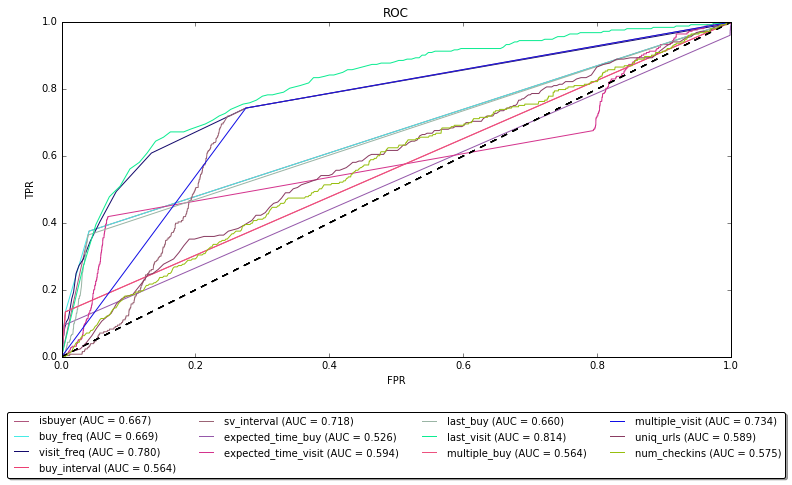

In [10]:

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

feature_auc_dict = {}
for col in data.drop('y_buy',1).columns:
    #Student put code here
    feature_auc_dict[col] = plotUnivariateROC(data[col],Y,col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

Next we want to add both of the dictionaries created above into a data frame.

In [15]:
#Student - Add auc and mi each to a single dataframe
df_auc = pd.DataFrame(pd.Series(feature_auc_dict),columns=['auc'])
df_mi = pd.DataFrame(pd.Series(feature_mi_dict),columns=['mi'])

#Student - Now merge the two on the feature name
feat_imp_df = df_auc.merge(df_mi,left_index=True,right_index=True) # shift+tab
feat_imp_df

,auc,mi
buy_freq,0.668931,0.005993
buy_interval,0.564296,0.008530
expected_time_buy,0.526401,0.020868
expected_time_visit,0.594029,0.101453
isbuyer,0.667206,0.000798
last_buy,0.660148,0.067251
last_visit,0.814216,0.196211
multiple_buy,0.564313,0.000000
multiple_visit,0.733904,0.001310
num_checkins,0.574946,0.228362


To put the different metrics on the same scale, we'll use pandas rank() method for each feature.

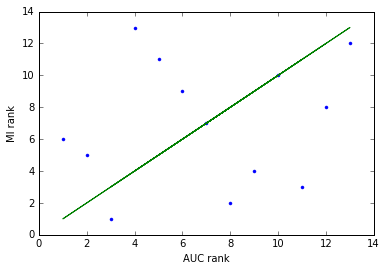

In [18]:
#Student - Now create a df that holds the ranks of auc and mi 
feat_ranks = feat_imp_df.rank(axis=0, ascending=True)

#Student - Plot the two ranks
plt.plot(feat_ranks.auc, feat_ranks.mi,'.')
plt.plot(feat_ranks.auc, feat_ranks.auc,)
#Student - Plot a y=x reference line
plt.xlabel('AUC rank')
plt.ylabel('MI rank')

In [10]:
#Student - Now create lists of top 5 features for both auc and mi
top5_auc = 
top5_mi = 
top5_auc, top5_mi

The next step is the conclusive step from all the analysis done above. We want to test which method above can be used to produce the best subset of features. What we'll do is use the top 5 features ranked by both AUC and the decision tree feature importance and compare them against each other with different algorithms.

In [14]:
'''
Now do the following
1. Split the data into 80/20 train/test
2. For each set of features:
- build a decision trees max_depth = 5 
- build a logistic regression C = 100
- get the auc and log-loss on the test set
'''


def getLogLoss(Ps, Ys, eps = 10**-6):
    return ((Ys == 1) * np.log(Ps + eps) + (Ys == 0) * np.log(1 - Ps + eps)).mean()

#Student - Split into train and test randomly without using sklearn package
#Note, there are many ways to do this:

train_pct = 0.8
#1. create an array of n random uniform variables drawn on [0,1] range
rand = 
#2. Convert to boolean where True = random number < train_pct
rand_filt = 

#Student - Use the filter to index data into training and test data sets
train = 
test = 


fsets = [top5_auc, top5_mi]
fset_descr = ['auc', 'mi']
mxdepths = [5]
Cs = [10**2]


#Set up plotting box
fig = plt.figure(figsize = (15, 8))
ax = plt.subplot(111)



for i, fset in enumerate(fsets):
    
    descr = fset_descr[i]
    #set training and testing data
    Y_train = train['y_buy']
    X_train = train[fset]
    Y_test = test['y_buy']
    X_test = test[fset]
    
    
    #Student - for all d in mxdepths and C in Cs, build DT's and LR's respectively
    # get the predictions on the test set and also get the log-loss, then plot
    
    #Student - instantiate the class
    dt = 
    #Don't forget to fit the tree
    #Now make a prediction
    preds_dt = 
    #Now compute the log-loss
    ll_dt = 
        
    plotUnivariateROC(preds_dt, Y_test, '{}:DT:md={}:(LL={})'.format(descr, d, round(ll_dt, 3)))

        
    #Student - instantiate the class
    lr = 
    #Don't forget to fit the LR
    #Now make a prediction
    preds_lr = 
    #Now compute the log-loss
    ll_lr = 

    plotUnivariateROC(preds_lr, Y_test, '{}:LR:C={}:(LL={})'.format(descr, C, round(ll_lr, 3)))

    
# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 2, prop = {'size':10})
